# Тестовый файл для удобного запуска и отладки составных частей бота 

In [54]:
%reload_ext autoreload
%autoreload 2

In [196]:
import os
from dotenv import load_dotenv
from tinkoff.invest import Client

from tinkoff.invest import CandleInterval
from datetime import datetime

load_dotenv()

TOKEN = os.getenv("INVEST_TOKEN")

TICKER = 'RNFT'
FIGI = 'BBG00F9XX7H4'

In [197]:
from trader_bot import ScalpingBot

In [209]:
year, month, day, tmz = 2024, 3, 15, 3

date_from = datetime(year, month, day, 10 - tmz, 39)
date_to = datetime(year, month, day, 17 - tmz, 44)

# вот тут хак нужен выбирает не корректно при наличии сдвига временного справа, а левый - норм
date_from_for_candles = datetime(year, month, day, 9 - tmz, 55)
date_to_for_candles = datetime(year, month, day, 19, 0)

print("Начальная дата и время:", date_from)
print("Конечная дата и время:", date_to)

Начальная дата и время: 2024-03-15 07:39:00
Конечная дата и время: 2024-03-15 14:44:00


In [199]:
with Client(TOKEN) as client: 
    candles_1_min = client.market_data.get_candles(
        figi=FIGI,
        from_=date_from_for_candles,
        to=date_to_for_candles,
        interval=CandleInterval.CANDLE_INTERVAL_1_MIN
    )
    
    # candles_5_min = client.market_data.get_candles(
    #     figi=FIGI,
    #     from_=date_from,
    #     to=date_to,
    #     interval=CandleInterval.CANDLE_INTERVAL_5_MIN
    # )

In [200]:
len(candles_1_min.candles)

526

# Тестовая система

In [212]:
from datetime import timedelta
from test_env.client_test_env import ClientTestEnvHelper
from test_env.logger_test_env import LoggerTestEnvHelper
from test_env.time_test_env import TimeTestEnvHelper
from test_env.accounting_test_env import AccountingTestEnvHelper

time_helper = TimeTestEnvHelper(date_from)
logger_helper = LoggerTestEnvHelper(time_helper)
client_helper = ClientTestEnvHelper(TICKER, logger_helper, time_helper, candles_1_min)
accounting_helper = AccountingTestEnvHelper(client_helper)
# todo вот это пока задается костылем  
client_helper.set_ticker_params(1, 0.1, 'BBG00F9XX7H4', 'RUR')

# ---------------

bot = ScalpingBot(
    TOKEN, 
    TICKER,

    profit_steps=5,
    stop_loss_percent=1.0,
    candles_count=3,

    time_helper=time_helper,
    logger_helper=logger_helper,
    client_helper=client_helper,
    accounting_helper=accounting_helper,
    )

# итератор по минутам для заданного времени
def datetime_iterator(start_datetime, end_datetime):
    current_datetime = start_datetime
    while current_datetime <= end_datetime:
        yield current_datetime
        current_datetime += timedelta(minutes=1)

bot.time.set_time(date_from)
bot.time.sleep(0)

# Использование итератора для вывода каждой пары час-минута
for dt in datetime_iterator(date_from, date_to):
    # задаем время
    time_helper.set_time(dt)
    
    candle = client_helper.get_candle(dt)
    if candle is None:
        logger_helper.error(f"No candle for {dt}")        
        continue
    
    # задаем текущее значение свечи
    client_helper.set_current_candle(candle)
    
    # анализируем заявки - успешные помечаем
    if bot.buy_order:
        buy_price = client_helper.quotation_to_float(bot.buy_order.initial_order_price)
        low_buy_price = client_helper.quotation_to_float(candle.low)
        if buy_price >= low_buy_price:
            client_helper.buy_order_executed = True
            client_helper.buy_order_executed_on_border = buy_price == low_buy_price

    if bot.sell_order:
        sell_price = client_helper.quotation_to_float(bot.sell_order.initial_order_price)
        high_sell_price = client_helper.quotation_to_float(candle.high)
        if sell_price <= high_sell_price:
            client_helper.sell_order_executed = True
            client_helper.sell_order_executed_on_border = sell_price == high_sell_price

    # если пора просыпаться
    if time_helper.is_time_to_awake():
        # print(dt.strftime("%H:%M"))
        # запускаем итерацию торгового алгоритма
        bot.run_iteration()

bot.stop()

print()
print(f"Изменение баланса: {round(accounting_helper.sum, 2)} {client_helper.currency}")
print(f"Операций: {client_helper.total_completed_orders}, "
      f"из них граничных {client_helper.total_completed_orders_on_border} "
      f"({round(100 *client_helper.total_completed_orders_on_border / client_helper.total_completed_orders, 2)}%)")

10:39 - INIT 
     figi - BBG00F9XX7H4 (RNFT)
     candles_count - 3
     min profit - 5 steps * 0.1 = 0.5 RUR
     stop_loss_percent - 1.0 %
     commission - 0.05 %
     no_operation_timeout_seconds - 300 sec
     sleep_trading - 300 sec
     sleep_no_trade - 300 sec

10:39 - Сужаем диапазон на 2 шага
10:39 - Размещена заявка на покупку по 173.7
10:39 - Ждем следующего цикла, sleep 300
10:44 - 5.0 минут без активности. Снимаем и переставляем заявки.
10:44 - Buy order 111, price=173.7 canceled
10:44 - Сужаем диапазон на 2 шага
10:44 - Размещена заявка на покупку по 173.8
10:44 - Ждем следующего цикла, sleep 300
10:49 - 5.0 минут без активности. Снимаем и переставляем заявки.
10:49 - Buy order 111, price=173.8 canceled
10:49 - Пока не торгуем. Ожидаемая разница в торгах - 0.4, а требуется минимум 0.5 
10:49 - Ждем следующего цикла, sleep 300
10:54 - 5.0 минут без активности. Снимаем и переставляем заявки.
10:54 - Пока не торгуем. Ожидаемая разница в торгах - 0.4, а требуется минимум 0.

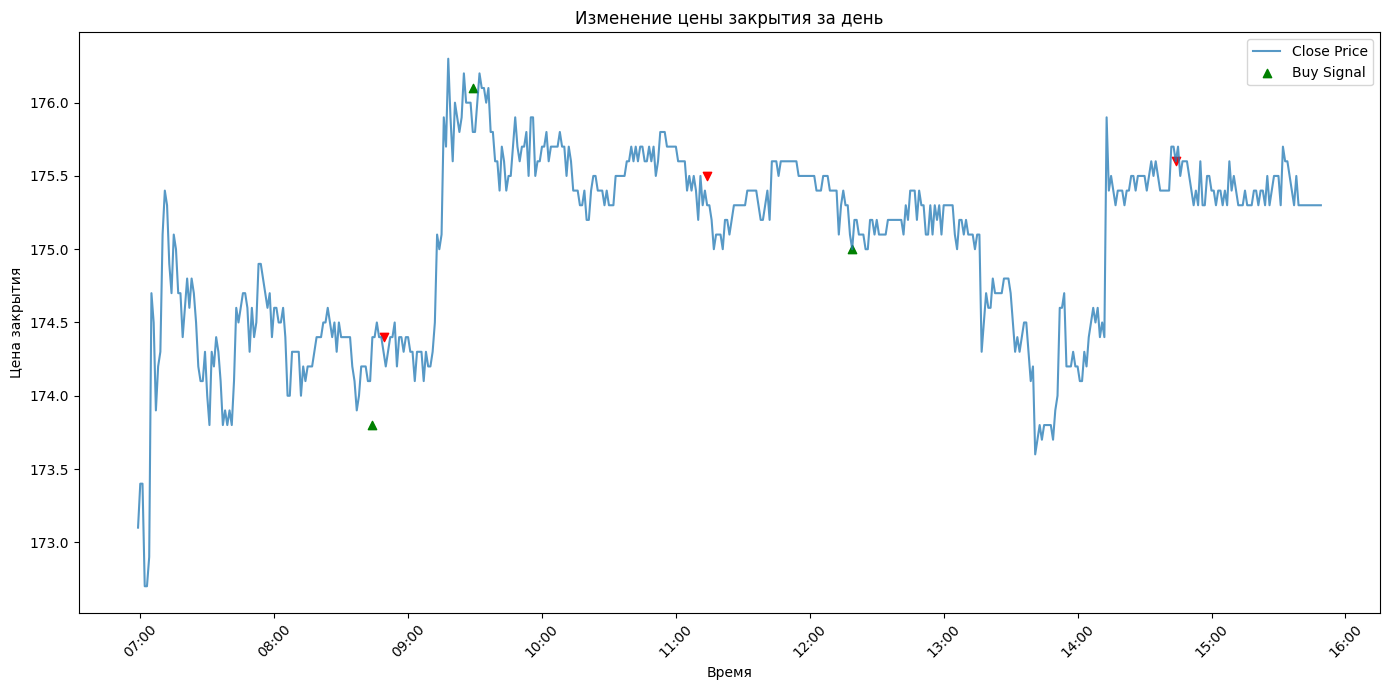

In [214]:
from tinkoff.invest import Quotation
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import numpy as np

# Функция для преобразования Quotation в float
def q2f(quotation: Quotation, digits=2):
    return round(quotation.units + quotation.nano * 1e-9, digits)

# Подготовка данных для графика
times = [candle.time for candle in candles_1_min.candles]  # Время каждой свечи
close_prices = [q2f(candle.close) for candle in candles_1_min.candles]  # Цены закрытия каждой свечи

# Визуализация
fig, ax = plt.subplots(figsize=(14, 7))

# Построение графика изменения цены закрытия
plt.plot(times, close_prices, label='Close Price', alpha=0.75)

for i, deal in enumerate(accounting_helper.deals):
    if deal['type'] == 'buy':
        plt.scatter(deal['time'], deal['price'], color='green', marker='^', alpha=1, label='Buy Signal' if i == 0 else "")
    elif deal['type'] == 'sell':
        plt.scatter(deal['time'], deal['price'], color='red', marker='v', alpha=1, label='Sell Signal' if i == 0 else "")


# Форматирование оси времени
ax.xaxis_date()  # Интерпретировать ось X как даты
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Интервал в один час
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))  # Формат времени

plt.xticks(rotation=45)  # Поворот меток времени
plt.title('Изменение цены закрытия за день')
plt.xlabel('Время')
plt.ylabel('Цена закрытия')
plt.legend()
plt.tight_layout()  # Автоматическая корректировка подложки
plt.show()